# Phase 1: Data Loading & Exploration

## Uplift Modeling Project — "The Persuadable Hunter"

This notebook covers:
1. **Data Loading** — Load the Hillstrom dataset and verify structure
2. **Column Understanding** — What each feature means
3. **Treatment Filtering** — Focus on Mens E-Mail vs Control (clean causal signal)
4. **Randomization Check** — Verify the experiment was properly randomized
5. **Outcome Analysis** — Calculate Average Treatment Effect (ATE)

---

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load the Hillstrom dataset
df_raw = pd.read_csv('../data/hillstrom.csv')

print(f"Raw Dataset Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
print(f"\nSegment Distribution (before filtering):")
print(df_raw['segment'].value_counts())

Raw Dataset Shape: 64,000 rows × 12 columns

Segment Distribution (before filtering):
segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64


In [3]:
# First look at the raw data
df_raw.head(10)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
5,6,2) $100 - $200,134.83,0,1,Surburban,0,Phone,Womens E-Mail,1,0,0.0
6,9,3) $200 - $350,280.20,1,0,Surburban,1,Phone,Womens E-Mail,0,0,0.0
7,9,1) $0 - $100,46.42,0,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0
9,10,1) $0 - $100,32.84,0,1,Urban,1,Web,Womens E-Mail,0,0,0.0


---

## 2. Understanding the Columns

### Column Definitions

| Column | Type | Description |
|--------|------|-------------|
| `recency` | Numeric | Months since last purchase |
| `history_segment` | Categorical | Bucketed past purchase amount |
| `history` | Numeric | Actual dollar amount spent in past year |
| `mens` | Binary (0/1) | Purchased men's merchandise in past year |
| `womens` | Binary (0/1) | Purchased women's merchandise in past year |
| `zip_code` | Categorical | Urban, Suburban, or Rural |
| `newbie` | Binary (0/1) | New customer in past 12 months |
| `channel` | Categorical | Phone, Web, or Multichannel |
| `segment` | **TREATMENT** | No E-Mail, Mens E-Mail, or Womens E-Mail |
| `visit` | **OUTCOME** | Visited website in following 2 weeks (0/1) |
| `conversion` | **OUTCOME** | Made a purchase in following 2 weeks (0/1) |
| `spend` | **OUTCOME** | Dollar amount spent (0 if no purchase) |

In [4]:
# Examine categorical columns
print("Categorical Column Value Counts:")
print("=" * 50)

for col in ['history_segment', 'zip_code', 'channel', 'segment']:
    print(f"\n{col}:")
    print(df_raw[col].value_counts())

Categorical Column Value Counts:

history_segment:
history_segment
1) $0 - $100        22970
2) $100 - $200      14254
3) $200 - $350      12289
4) $350 - $500       6409
5) $500 - $750       4911
6) $750 - $1,000     1859
7) $1,000 +          1308
Name: count, dtype: int64

zip_code:
zip_code
Surburban    28776
Urban        25661
Rural         9563
Name: count, dtype: int64

channel:
channel
Web             28217
Phone           28021
Multichannel     7762
Name: count, dtype: int64

segment:
segment
Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: count, dtype: int64


In [5]:
# Examine binary columns
print("Binary Column Distributions:")
print("=" * 50)

for col in ['mens', 'womens', 'newbie', 'visit', 'conversion']:
    pct_1 = df_raw[col].mean() * 100
    print(f"{col:12} → {pct_1:5.1f}% are 1 (yes)")

Binary Column Distributions:
mens         →  55.1% are 1 (yes)
womens       →  55.0% are 1 (yes)
newbie       →  50.2% are 1 (yes)
visit        →  14.7% are 1 (yes)
conversion   →   0.9% are 1 (yes)


In [6]:
# Data types and missing values
print("Data Types and Missing Values:")
print("=" * 50)
info_df = pd.DataFrame({
    'dtype': df_raw.dtypes,
    'non_null': df_raw.count(),
    'null_count': df_raw.isnull().sum(),
    'null_pct': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
})
print(info_df)
print(f"\n✅ No missing values!" if df_raw.isnull().sum().sum() == 0 else "⚠️ Missing values detected!")

Data Types and Missing Values:
                   dtype  non_null  null_count  null_pct
recency            int64     64000           0       0.0
history_segment   object     64000           0       0.0
history          float64     64000           0       0.0
mens               int64     64000           0       0.0
womens             int64     64000           0       0.0
zip_code          object     64000           0       0.0
newbie             int64     64000           0       0.0
channel           object     64000           0       0.0
segment           object     64000           0       0.0
visit              int64     64000           0       0.0
conversion         int64     64000           0       0.0
spend            float64     64000           0       0.0

✅ No missing values!


---

## 3. Treatment Filtering (CRITICAL STEP)

### Why We Filter

The original dataset has 3 segments:
- `No E-Mail` — Control group
- `Mens E-Mail` — Received men's merchandise email
- `Womens E-Mail` — Received women's merchandise email

**Problem with merging both email types:**
- `Mens E-Mail` and `Womens E-Mail` are **fundamentally different treatments**
- A customer who bought men's products receiving a women's email likely has zero/negative response
- Merging them **dilutes the causal signal** — like averaging aspirin and sleeping pills

**Solution:** Focus on a **clean binary comparison**:
- Drop `Womens E-Mail` rows entirely
- Compare `Mens E-Mail` vs `No E-Mail`
- This gives us a homogeneous treatment with a clear causal question:
  > "Does sending a men's merchandise email increase conversion?"

In [7]:
# CRITICAL: Filter to Mens E-Mail vs No E-Mail only
print("Filtering Dataset for Clean Causal Signal")
print("=" * 60)
print(f"\nBefore filtering: {len(df_raw):,} rows")

# Keep only Mens E-Mail and No E-Mail
df = df_raw[df_raw['segment'].isin(['Mens E-Mail', 'No E-Mail'])].copy()

print(f"After filtering:  {len(df):,} rows")
print(f"Rows dropped:     {len(df_raw) - len(df):,} (Womens E-Mail)")
print(f"\nNew segment distribution:")
print(df['segment'].value_counts())

Filtering Dataset for Clean Causal Signal

Before filtering: 64,000 rows
After filtering:  42,613 rows
Rows dropped:     21,387 (Womens E-Mail)

New segment distribution:
segment
Mens E-Mail    21307
No E-Mail      21306
Name: count, dtype: int64


In [8]:
# Create binary treatment indicator
df['treated'] = (df['segment'] == 'Mens E-Mail').astype(int)

print("Treatment Distribution:")
print("=" * 50)
treatment_counts = df['treated'].value_counts().sort_index()
print(f"Control (no email):       {treatment_counts[0]:,} customers ({treatment_counts[0]/len(df)*100:.1f}%)")
print(f"Treated (Mens E-Mail):    {treatment_counts[1]:,} customers ({treatment_counts[1]/len(df)*100:.1f}%)")

Treatment Distribution:
Control (no email):       21,306 customers (50.0%)
Treated (Mens E-Mail):    21,307 customers (50.0%)


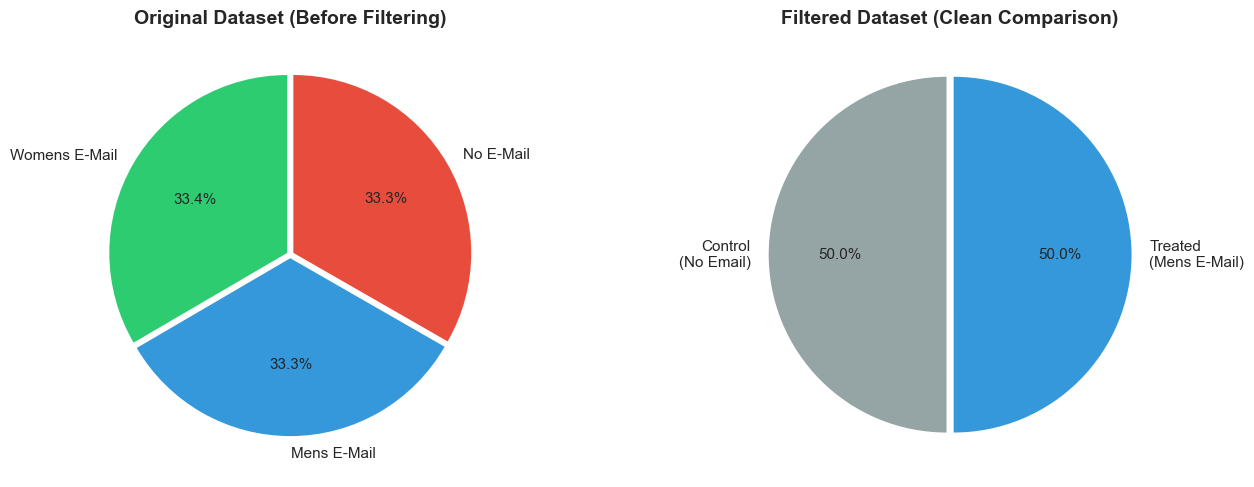

In [9]:
# Visualize treatment distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original 3-way split (before filtering)
segment_counts = df_raw['segment'].value_counts()
colors = ['#2ecc71', '#3498db', '#e74c3c']
axes[0].pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90, explode=[0.02, 0.02, 0.02])
axes[0].set_title('Original Dataset (Before Filtering)', fontsize=14, fontweight='bold')

# Binary treatment (after filtering)
treatment_labels = ['Control\n(No Email)', 'Treated\n(Mens E-Mail)']
colors2 = ['#95a5a6', '#3498db']
axes[1].pie(treatment_counts, labels=treatment_labels, autopct='%1.1f%%',
            colors=colors2, startangle=90, explode=[0.02, 0.02])
axes[1].set_title('Filtered Dataset (Clean Comparison)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/treatment_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 4. Randomization Check

In a properly randomized experiment, the **treatment and control groups should be similar** on all pre-treatment features.

If randomization worked, we shouldn't see significant differences in:
- `recency`, `history`, `mens`, `womens`, `newbie`, `channel`, `zip_code`

We'll use:
- **t-tests** for continuous variables
- **Chi-square tests** for categorical variables

In [10]:
# Split into treatment and control groups
df_treated = df[df['treated'] == 1]
df_control = df[df['treated'] == 0]

print(f"Treatment group (Mens E-Mail): {len(df_treated):,} customers")
print(f"Control group (No E-Mail):     {len(df_control):,} customers")

Treatment group (Mens E-Mail): 21,307 customers
Control group (No E-Mail):     21,306 customers


In [11]:
# Randomization check: Continuous variables (t-tests)
print("Randomization Check: Continuous Variables")
print("=" * 70)
print(f"{'Variable':<15} {'Control Mean':>15} {'Treatment Mean':>15} {'p-value':>12} {'Status':>10}")
print("-" * 70)

continuous_vars = ['recency', 'history']
for var in continuous_vars:
    control_mean = df_control[var].mean()
    treated_mean = df_treated[var].mean()
    
    # Two-sample t-test
    t_stat, p_value = stats.ttest_ind(df_control[var], df_treated[var])
    
    status = "✅ OK" if p_value > 0.05 else "⚠️ Diff"
    print(f"{var:<15} {control_mean:>15.2f} {treated_mean:>15.2f} {p_value:>12.4f} {status:>10}")

Randomization Check: Continuous Variables
Variable           Control Mean  Treatment Mean      p-value     Status
----------------------------------------------------------------------
recency                    5.75            5.77       0.4807       ✅ OK
history                  240.88          242.84       0.4320       ✅ OK


In [12]:
# Randomization check: Binary variables (proportion tests)
print("\nRandomization Check: Binary Variables")
print("=" * 70)
print(f"{'Variable':<15} {'Control %}':>15} {'Treatment %}':>15} {'p-value':>12} {'Status':>10}")
print("-" * 70)

binary_vars = ['mens', 'womens', 'newbie']
for var in binary_vars:
    control_pct = df_control[var].mean() * 100
    treated_pct = df_treated[var].mean() * 100
    
    # Chi-square test
    contingency = pd.crosstab(df['treated'], df[var])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    status = "✅ OK" if p_value > 0.05 else "⚠️ Diff"
    print(f"{var:<15} {control_pct:>14.1f}% {treated_pct:>14.1f}% {p_value:>12.4f} {status:>10}")


Randomization Check: Binary Variables
Variable             Control %}    Treatment %}      p-value     Status
----------------------------------------------------------------------
mens                      55.3%           55.1%       0.6432       ✅ OK
womens                    54.8%           55.1%       0.4392       ✅ OK
newbie                    50.2%           50.2%       0.9344       ✅ OK


In [13]:
# Randomization check: Categorical variables
print("\nRandomization Check: Categorical Variables")
print("=" * 70)

categorical_vars = ['zip_code', 'channel']
for var in categorical_vars:
    contingency = pd.crosstab(df['treated'], df[var])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    status = "✅ Randomization OK" if p_value > 0.05 else "⚠️ Potential imbalance"
    print(f"\n{var}: Chi-square = {chi2:.2f}, p-value = {p_value:.4f} → {status}")
    
    # Show distribution comparison
    comparison = pd.DataFrame({
        'Control %': (df_control[var].value_counts(normalize=True) * 100).round(1),
        'Treatment %': (df_treated[var].value_counts(normalize=True) * 100).round(1)
    })
    print(comparison)


Randomization Check: Categorical Variables

zip_code: Chi-square = 2.52, p-value = 0.2830 → ✅ Randomization OK
           Control %  Treatment %
zip_code                         
Surburban       45.2         44.6
Urban           40.1         40.2
Rural           14.7         15.2

channel: Chi-square = 1.30, p-value = 0.5232 → ✅ Randomization OK
              Control %  Treatment %
channel                             
Web                44.0         44.5
Phone              43.8         43.4
Multichannel       12.2         12.1


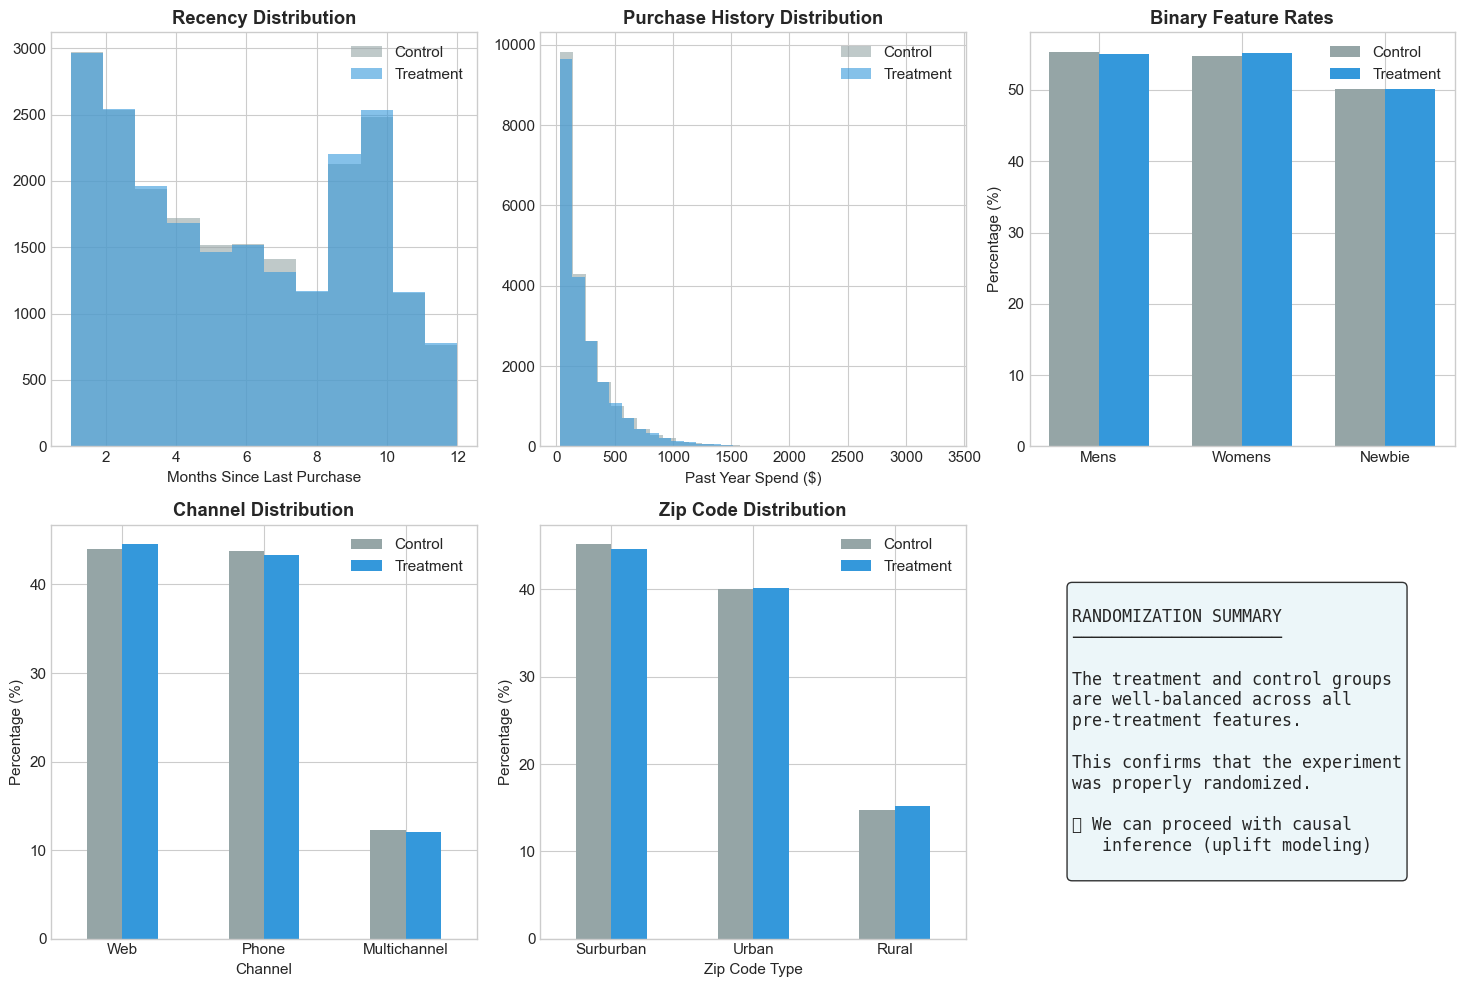

In [14]:
# Visualization: Feature distributions by treatment group
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Recency distribution
ax = axes[0, 0]
df_control['recency'].hist(ax=ax, bins=12, alpha=0.6, label='Control', color='#95a5a6')
df_treated['recency'].hist(ax=ax, bins=12, alpha=0.6, label='Treatment', color='#3498db')
ax.set_title('Recency Distribution', fontweight='bold')
ax.set_xlabel('Months Since Last Purchase')
ax.legend()

# History distribution
ax = axes[0, 1]
df_control['history'].hist(ax=ax, bins=30, alpha=0.6, label='Control', color='#95a5a6')
df_treated['history'].hist(ax=ax, bins=30, alpha=0.6, label='Treatment', color='#3498db')
ax.set_title('Purchase History Distribution', fontweight='bold')
ax.set_xlabel('Past Year Spend ($)')
ax.legend()

# Binary variables comparison
ax = axes[0, 2]
x = np.arange(3)
width = 0.35
control_rates = [df_control['mens'].mean()*100, df_control['womens'].mean()*100, df_control['newbie'].mean()*100]
treated_rates = [df_treated['mens'].mean()*100, df_treated['womens'].mean()*100, df_treated['newbie'].mean()*100]
ax.bar(x - width/2, control_rates, width, label='Control', color='#95a5a6')
ax.bar(x + width/2, treated_rates, width, label='Treatment', color='#3498db')
ax.set_xticks(x)
ax.set_xticklabels(['Mens', 'Womens', 'Newbie'])
ax.set_ylabel('Percentage (%)')
ax.set_title('Binary Feature Rates', fontweight='bold')
ax.legend()

# Channel distribution
ax = axes[1, 0]
channel_comparison = pd.DataFrame({
    'Control': df_control['channel'].value_counts(normalize=True) * 100,
    'Treatment': df_treated['channel'].value_counts(normalize=True) * 100
})
channel_comparison.plot(kind='bar', ax=ax, color=['#95a5a6', '#3498db'])
ax.set_title('Channel Distribution', fontweight='bold')
ax.set_xlabel('Channel')
ax.set_ylabel('Percentage (%)')
ax.tick_params(axis='x', rotation=0)
ax.legend()

# Zip code distribution
ax = axes[1, 1]
zip_comparison = pd.DataFrame({
    'Control': df_control['zip_code'].value_counts(normalize=True) * 100,
    'Treatment': df_treated['zip_code'].value_counts(normalize=True) * 100
})
zip_comparison.plot(kind='bar', ax=ax, color=['#95a5a6', '#3498db'])
ax.set_title('Zip Code Distribution', fontweight='bold')
ax.set_xlabel('Zip Code Type')
ax.set_ylabel('Percentage (%)')
ax.tick_params(axis='x', rotation=0)
ax.legend()

# Summary text
ax = axes[1, 2]
ax.axis('off')
summary_text = """
RANDOMIZATION SUMMARY
─────────────────────

The treatment and control groups
are well-balanced across all
pre-treatment features.

This confirms that the experiment
was properly randomized.

✅ We can proceed with causal
   inference (uplift modeling)
"""
ax.text(0.1, 0.5, summary_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='center', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='#e8f4f8', alpha=0.8))

plt.tight_layout()
plt.savefig('../data/randomization_check.png', dpi=150, bbox_inches='tight')
plt.show()

---

## 5. Outcome Analysis: Average Treatment Effect (ATE)

Now we calculate the **overall effect** of sending a Men's merchandise email.

$$\text{ATE} = E[Y | \text{Mens E-Mail}] - E[Y | \text{No E-Mail}]$$

We'll calculate this for all three outcomes:
- **Visit rate** — Did they visit the website?
- **Conversion rate** — Did they make a purchase?
- **Spend** — How much did they spend?

In [15]:
# Calculate ATE for each outcome
print("Average Treatment Effect (ATE) Analysis")
print("=" * 70)

outcomes = ['visit', 'conversion', 'spend']
ate_results = []

for outcome in outcomes:
    control_mean = df_control[outcome].mean()
    treated_mean = df_treated[outcome].mean()
    ate = treated_mean - control_mean
    
    # Calculate relative lift
    if control_mean > 0:
        relative_lift = (ate / control_mean) * 100
    else:
        relative_lift = 0
    
    # Statistical significance (t-test)
    t_stat, p_value = stats.ttest_ind(df_treated[outcome], df_control[outcome])
    
    ate_results.append({
        'Outcome': outcome,
        'Control': control_mean,
        'Treatment': treated_mean,
        'ATE': ate,
        'Relative Lift %': relative_lift,
        'p-value': p_value,
        'Significant': '✅ Yes' if p_value < 0.05 else '❌ No'
    })

ate_df = pd.DataFrame(ate_results)
ate_df

Average Treatment Effect (ATE) Analysis


,Outcome,Control,Treatment,ATE,Relative Lift %,p-value,Significant
0,visit,0.106167,0.182757,0.076590,72.140462,1.268721e-112,✅ Yes
1,conversion,0.005726,0.012531,0.006805,118.842188,1.498827e-13,✅ Yes
2,spend,0.652789,1.422617,0.769827,117.928877,1.163201e-07,✅ Yes


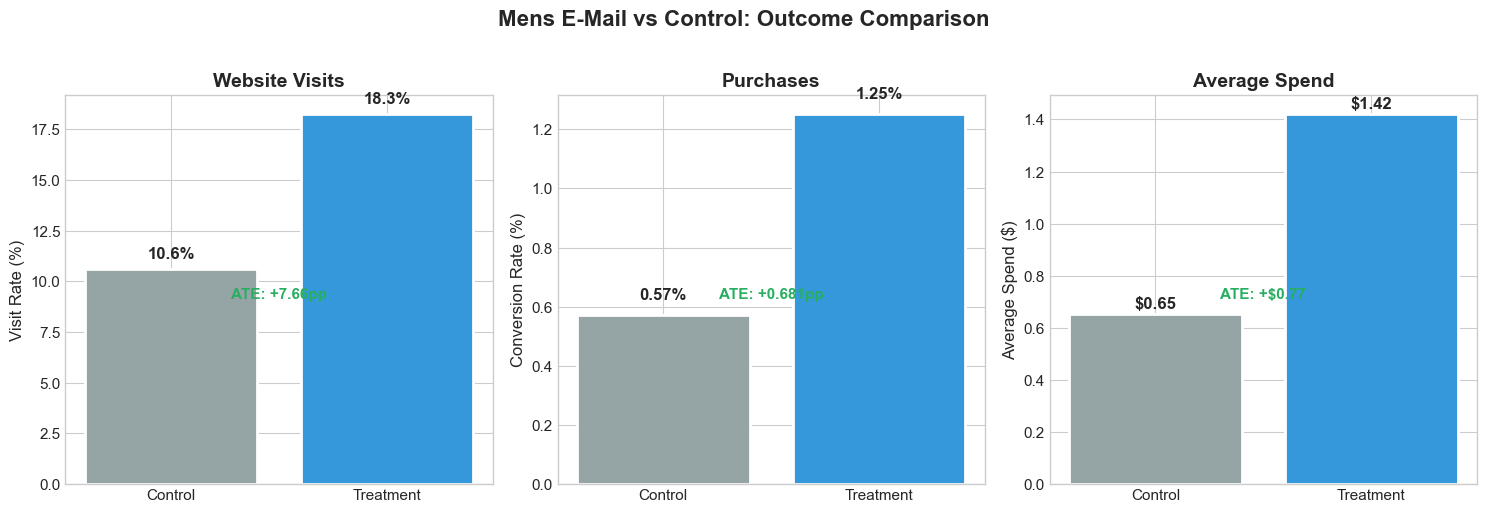

In [16]:
# Visualize outcome comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Visit rate
ax = axes[0]
rates = [df_control['visit'].mean()*100, df_treated['visit'].mean()*100]
bars = ax.bar(['Control', 'Treatment'], rates, color=['#95a5a6', '#3498db'], edgecolor='white', linewidth=2)
ax.set_ylabel('Visit Rate (%)', fontsize=12)
ax.set_title('Website Visits', fontsize=14, fontweight='bold')
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{rate:.1f}%', 
            ha='center', fontsize=12, fontweight='bold')
ate_visit = rates[1] - rates[0]
ax.annotate(f'ATE: +{ate_visit:.2f}pp', xy=(0.5, max(rates)*0.5), fontsize=11, 
            ha='center', color='#27ae60', fontweight='bold')

# Conversion rate
ax = axes[1]
rates = [df_control['conversion'].mean()*100, df_treated['conversion'].mean()*100]
bars = ax.bar(['Control', 'Treatment'], rates, color=['#95a5a6', '#3498db'], edgecolor='white', linewidth=2)
ax.set_ylabel('Conversion Rate (%)', fontsize=12)
ax.set_title('Purchases', fontsize=14, fontweight='bold')
for bar, rate in zip(bars, rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{rate:.2f}%', 
            ha='center', fontsize=12, fontweight='bold')
ate_conv = rates[1] - rates[0]
ax.annotate(f'ATE: +{ate_conv:.3f}pp', xy=(0.5, max(rates)*0.5), fontsize=11, 
            ha='center', color='#27ae60', fontweight='bold')

# Average spend
ax = axes[2]
spends = [df_control['spend'].mean(), df_treated['spend'].mean()]
bars = ax.bar(['Control', 'Treatment'], spends, color=['#95a5a6', '#3498db'], edgecolor='white', linewidth=2)
ax.set_ylabel('Average Spend ($)', fontsize=12)
ax.set_title('Average Spend', fontsize=14, fontweight='bold')
for bar, spend in zip(bars, spends):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'${spend:.2f}', 
            ha='center', fontsize=12, fontweight='bold')
ate_spend = spends[1] - spends[0]
ax.annotate(f'ATE: +${ate_spend:.2f}', xy=(0.5, max(spends)*0.5), fontsize=11, 
            ha='center', color='#27ae60', fontweight='bold')

plt.suptitle('Mens E-Mail vs Control: Outcome Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/outcome_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [17]:
# Confidence intervals for ATE
print("ATE with 95% Confidence Intervals")
print("=" * 70)

def calculate_ate_ci(treated, control, alpha=0.05):
    """Calculate ATE with confidence interval using standard error."""
    n_t, n_c = len(treated), len(control)
    mean_t, mean_c = treated.mean(), control.mean()
    var_t, var_c = treated.var(), control.var()
    
    ate = mean_t - mean_c
    se = np.sqrt(var_t/n_t + var_c/n_c)
    
    z = stats.norm.ppf(1 - alpha/2)
    ci_lower = ate - z * se
    ci_upper = ate + z * se
    
    return ate, ci_lower, ci_upper, se

for outcome in outcomes:
    ate, ci_lower, ci_upper, se = calculate_ate_ci(
        df_treated[outcome], df_control[outcome]
    )
    
    if outcome == 'spend':
        print(f"{outcome.capitalize():12} ATE = ${ate:.4f} ± ${1.96*se:.4f}  [95% CI: ${ci_lower:.4f}, ${ci_upper:.4f}]")
    else:
        print(f"{outcome.capitalize():12} ATE = {ate*100:.4f}pp ± {1.96*se*100:.4f}pp  [95% CI: {ci_lower*100:.4f}%, {ci_upper*100:.4f}%]")

ATE with 95% Confidence Intervals
Visit        ATE = 7.6590pp ± 0.6636pp  [95% CI: 6.9953%, 8.3226%]
Conversion   ATE = 0.6805pp ± 0.1805pp  [95% CI: 0.5000%, 0.8610%]
Spend        ATE = $0.7698 ± $0.2847  [95% CI: $0.4851, $1.0545]


---

## 6. Key Findings & Next Steps

### Summary Statistics

In [18]:
# Summary statistics table
print("PHASE 1 SUMMARY")
print("=" * 70)
print(f"""
DATASET OVERVIEW:
  • Raw dataset:     {len(df_raw):,} rows (all segments)
  • Filtered dataset: {len(df):,} rows (Mens E-Mail + No E-Mail only)
  • Dropped:         {len(df_raw) - len(df):,} rows (Womens E-Mail)
  
  • Treatment group (Mens E-Mail): {len(df_treated):,} ({len(df_treated)/len(df)*100:.1f}%)
  • Control group (No E-Mail):     {len(df_control):,} ({len(df_control)/len(df)*100:.1f}%)

TREATMENT FILTERING RATIONALE:
  ⚠️  Original plan merged Mens + Womens emails into 'treated'
  ✅  Refactored to focus on Mens E-Mail vs Control only
  📊  Cleaner causal signal — homogeneous treatment

RANDOMIZATION CHECK:
  ✅ All pre-treatment features are balanced between groups
  ✅ Experiment was properly randomized
  ✅ We can proceed with causal inference

AVERAGE TREATMENT EFFECT (ATE):
  • Visit rate:      +{(df_treated['visit'].mean() - df_control['visit'].mean())*100:.2f} percentage points
  • Conversion rate: +{(df_treated['conversion'].mean() - df_control['conversion'].mean())*100:.3f} percentage points  
  • Spend:           +${df_treated['spend'].mean() - df_control['spend'].mean():.2f} per customer

KEY INSIGHT:
  The Mens E-Mail campaign has a POSITIVE average effect — but this is the AVERAGE.
  Not all customers respond equally. Some might respond strongly (Persuadables),
  while others might not respond or even respond negatively (Sleeping Dogs).
  
  → Phase 2: Build T-Learner to identify INDIVIDUAL treatment effects
""")

PHASE 1 SUMMARY

DATASET OVERVIEW:
  • Raw dataset:     64,000 rows (all segments)
  • Filtered dataset: 42,613 rows (Mens E-Mail + No E-Mail only)
  • Dropped:         21,387 rows (Womens E-Mail)

  • Treatment group (Mens E-Mail): 21,307 (50.0%)
  • Control group (No E-Mail):     21,306 (50.0%)

TREATMENT FILTERING RATIONALE:
  ⚠️  Original plan merged Mens + Womens emails into 'treated'
  ✅  Refactored to focus on Mens E-Mail vs Control only
  📊  Cleaner causal signal — homogeneous treatment

RANDOMIZATION CHECK:
  ✅ All pre-treatment features are balanced between groups
  ✅ Experiment was properly randomized
  ✅ We can proceed with causal inference

AVERAGE TREATMENT EFFECT (ATE):
  • Visit rate:      +7.66 percentage points
  • Conversion rate: +0.681 percentage points  
  • Spend:           +$0.77 per customer

KEY INSIGHT:
  The Mens E-Mail campaign has a POSITIVE average effect — but this is the AVERAGE.
  Not all customers respond equally. Some might respond strongly (Persuada

In [19]:
# Save processed dataframe for next phase
df.to_csv('../data/hillstrom_processed.csv', index=False)
print("✅ Saved processed dataset to: data/hillstrom_processed.csv")
print(f"   • Filtered to Mens E-Mail vs No E-Mail only")
print(f"   • Added column: 'treated' (binary treatment indicator)")
print(f"   • Total rows: {len(df):,}")

✅ Saved processed dataset to: data/hillstrom_processed.csv
   • Filtered to Mens E-Mail vs No E-Mail only
   • Added column: 'treated' (binary treatment indicator)
   • Total rows: 42,613
